In [ ]:
import Bio
import subprocess
import sklearn
import pymol
import re
from pymol import cmd
import glob
import re
import numpy as np

Build the fasta file from tsv.  Took Column 0, Part of Target ID from Column 34 and Sequence Data from Column 38

In [1]:
######################################################################
# Generating fasta file
# Input: df_pet.tsv
# Output: df_pet03438.fasta
# Take the df_pet.tsv file and generate df_pet03438.fasta            
######################################################################
lines = open("df_pet.tsv").readlines()
f_file = open("df_pet03438.fasta",'w')

for line in lines[1:]:
    cols = line.split("\t")
    if cols[34][0:4] == 'ENA|':
        f_file.write(">"+cols[0]+"|"+cols[34][4:16]+"\n"+cols[38]+"\n")
    else:
        str1=cols[34].partition("-flag")[0]
        f_file.write(">"+cols[0]+"|"+str1+"\n"+cols[38]+"\n")

f_file.close()


In [ ]:
######################################################################
# Adding reference sequence
# Input: reference.fasta df_pet03438.fasta
# Output: dfpetwRef.fasta
# Add reference sequence to our fasta file and generate dfpetwRef.fasta
######################################################################

!cat reference.fasta df_pet03438.fasta > dfpetwRef.fasta

In [ ]:
######################################################################
# Converting to cURL
# Input: dfpetwRef.fasta
# Output: ./outputwR/*.pdb
# convert2curl.sh 
######################################################################
!./convert2curl.sh
#the above shell script generate the curl_scriptR.sh
#curl_scriptR.sh is a set of curl commands to generate pdb files
!mv curl_scriptR.sh ./outputwR/.
#!./curl_scriptR.sh&

In [2]:
######################################################################
# Setup Name Array
# Input: ./outputwR/*.pdb
# Output: nameArr.txt
# Setup a numpy array for the names of the sequence in the order of the 
# original order in df_petwRef.fasta.  This is done here by reading the
# name of the PDB files in the order of file timestamp, from the earliest 
# to the latest, this order matches the order in df_petwRef.fasta
######################################################################
import glob
import numpy as np
import os

search_dir = './outputwR/'
fileList = list(filter(os.path.isfile, glob.glob(search_dir + "*")))
fileList.sort(key=lambda x: os.path.getmtime(x))

nFiles=len(fileList)
nameArr = np.empty(nFiles, dtype=object)
i = 0

for file in fileList:           # example for variable 'file': ./outputwR/112.pdb
    p1 = file.rfind('/')        # finds the last occurrence of '/'
    p2 = file.rfind('.')        # finds the last occurrence of '.'
    nameArr[i] = file[p1+1:p2]  # 112
    i +=1
   
print (nameArr)
print (len(nameArr))

np.savetxt('nameArr.txt',nameArr, delimiter=' ', fmt='%s')

./outputwR/29792.pdb


In [ ]:
######################################################################
# PyMOL align to RMSD
# Input: ./outputwR/*.pdb
# Output: myrmsd.txt
# Run the align function in PyMOL library for generate the all-against-all
# RMSD distance matrix (since this matrix is symmetric where (row index) =  
# (cloumn index), only the top half of the matrix is generated        
######################################################################
from pymol import cmd
import re
import numpy as np


# initialize a numpy matrix (square matrix)
distMatrix = np.empty((nFiles,nFiles))


#all-against-all RMSD
#calculate only the top triangle of the RMSD using pymol align,auto assign RMSD=0 if comparing to self 
for i, filei in enumerate(fileList):
    cmd.load(fileList[i],nameArr[i])         #pymol load the first sequence
    #it tooks about 2 hours, print statement here is just to make sure the programming is still running....
    print ("i=%d" % (i))
    
#   for j, filej in enumerate(fileList):     #This will calculate the entire n x n matrix (took too long), 
                                             #replace with half of the trangle below
    for j, filej in enumerate(fileList[i:], start=i):
        if (i==j):                           #auto assign rmsd to zero
            distMatrix[i][j] = 0             #also to avoid calling cmd.delete where i=j 
        else:
            cmd.load(fileList[j],nameArr[j])  
            distMatrix[i][j] = cmd.align('%s' % (nameArr[i]), '%s' %(nameArr[j]),cycles=5, quiet=1)[0]
            cmd.delete(nameArr[j])           #clean up, if not, the pymol align will not return the correct value

    cmd.delete(nameArr[i])                   #clean up
    
np.savetxt('myrmsd.txt',distMatrix, delimiter=' ') #save rmsd matrix (only half) for reloading later
np.set_printoptions(precision=2)

['sp' '112' '279' '328' '499' '520' '600' '667' '805' '824' '971' '1004'
 '1016' '1357' '1403' '1411' '1586' '1612' '1660' '1807' '1923' '2009'
 '2049' '2052' '2084' '2219' '2305' '2339' '2357' '2626' '2751' '2778'
 '2789' '2834' '2848' '3380' '3442' '3456' '3499' '3533' '3540' '3767'
 '3916' '3926' '3955' '3958' '3982' '4030' '4034' '4120' '4148' '4187'
 '4199' '4257' '4324' '4383' '4464' '4502' '4544' '4562' '4577' '4630'
 '4662' '4681' '4773' '5044' '5094' '5169' '5328' '5332' '5486' '5518'
 '5553' '5583' '5666' '5946' '6013' '6024' '6166' '6282' '6401' '6403'
 '6716' '6773' '6826' '6830' '6888' '6900' '6938' '6980' '6986' '7006'
 '7135' '7168' '7173' '7227' '7248' '7411' '7429' '7432' '7535' '7565'
 '7574' '7638' '7666' '7675' '7699' '7883' '7923' '7978' '8122' '8151'
 '8202' '8312' '8560' '8725' '8738' '8968' '9033' '9073' '9080' '9120'
 '9326' '9367' '9368' '9486' '9533' '9717' '9819' '9835' '9841' '9847'
 '9936' '9945' '10018' '10090' '10101' '10126' '10140' '10196' '10210'
 '10

In [72]:
## debug print statements

np.set_printoptions(precision=3)

print (nameArr[0])
#values = range(nFiles)
#for i in values:
#    print (distMatrix[0][i])
print (distMatrix[0].min())  
print (distMatrix[0].max()) 
print (np.min(distMatrix[0][distMatrix[0]>0]))
print (np.argmin(distMatrix[0][distMatrix[0]>0]))
print (distMatrix[0][251])
print ("66")
print (np.min(distMatrix[66][distMatrix[66]>0]))
print ("65")
print (np.min(distMatrix[65][distMatrix[65]>0]))

print (np.argmin(distMatrix[distMatrix>0]))
print (distMatrix[115][198])
#np.unravel_index(np.argmin(distMatrix[distMatrix>0]), distMatrix.shape)
mER = np.where(distMatrix>0, distMatrix, np.inf).min(axis=1)
print (np.min(mER))
print (np.argmin(mER))
print (np.min(distMatrix[115][distMatrix[115]>0]))
print (np.argmin(distMatrix[115][distMatrix[115]>0]))
print (distMatrix[115][138])
print (distMatrix[115][140])

sp
0.0
22.090829849243164
0.38861504197120667
250
0.38861504197120667
66
0.09688027203083038
65
0.004695270676165819
31205
0.6547858715057373
0.0029766380321234465
115
0.0029766380321234465
138
1.1021428108215332
0.0029766380321234465


In [2]:
#*********************************************************************
#********************re-run the code from here************************
#*********************************************************************
######################################################################
# Load data from files
# Input: myrmsd.txt  mysim.txt  nameArr.txt
# Output: populates distMatrix, dissimMatrix, and nameArr
# read from saved files and load onto the variables, also calculated 
# min/max values from various arrays, for max, used max method by numpy
# for min, we want minimum greater than 0
######################################################################



#load the rmsd distance matrix preiously calculated
#and populate the bottom half

#also load the dis-sim matrix and the sequences names 

import sklearn
import numpy as np
#import re

distMatrix = np.genfromtxt("myrmsd.txt", delimiter=" ")
dissimMatrix = np.genfromtxt("mysim.txt", delimiter=" ")
nameArr = np.loadtxt('nameArr.txt', dtype=object)

#print (distMatrix.shape)
#print (dissimMatrix.shape)
#print (nameArr.shape)


rmsdMinR = 1; rmsdRj = 0
rmsdMinA = 1; rmsdAi = 0; rmsdAj = 0
simMinR = 1; simRj = 0
simMinA = 1; simAi = 0; simAj = 0

values = range(len(distMatrix))
#print (values)
for i in values:
    for j in values[i+1:]:
        # fill the bottom half of the matrix
        distMatrix[j][i] = distMatrix[i][j]
        
        #Looking for the minimum RMSD and dissimiliarity distance (all-against-all)
        if distMatrix[i][j]!=0 and distMatrix[i][j] < rmsdMinA:
            rmsdMinA = distMatrix[i][j]
            rmsdAi = i
            rmsdAj = j
        if dissimMatrix[i][j]!=0 and dissimMatrix[i][j] < simMinA:
            simMinA = dissimMatrix[i][j]
            simAi = i
            simAj = j
                
rmsdMinR = np.min(distMatrix[0][distMatrix[0]>0])      #numpy min for array values > 0
rmsdRj = np.argmin(distMatrix[0][distMatrix[0]>0])+1   #array position where min occurs

simMinR = np.min(dissimMatrix[0][dissimMatrix[0]>0])
simRj = np.argmin(dissimMatrix[0][dissimMatrix[0]>0])+1 
                
         
print ("Minimum RMSD against reference sequence is %s with [0][%d] = %2f" 
       %(nameArr[rmsdRj],rmsdRj, rmsdMinR))
print ("Minimum RMSD all-against-all is %s vs. %s with [%d][%d] = %2f" 
       %(nameArr[rmsdAi], nameArr[rmsdAj], rmsdAi, rmsdAj, rmsdMinA))

print ("Minimum dissimiliar against reference sequence is %s with [0][%d] = %2f" 
       %(nameArr[simRj], simRj, simMinR))
print ("Minimum dissimiliar all-against-all is %s vs. %s with [%d][%d] = %2f" 
       %(nameArr[simAi], nameArr[simAj], simAi, simAj, simMinA))

print ("Maximum RMSD: %2f" %(distMatrix.max()))
print ("Maximum dissimiliar: %2f" %(dissimMatrix.max()))


Minimum RMSD against reference sequence is 28148 with [0][251] = 0.388615
Minimum RMSD all-against-all is 8725 vs. 10210 with [115][140] = 0.002977
Minimum dissimiliar against reference sequence is 29050 with [0][267] = 0.449612
Minimum dissimiliar all-against-all is 10196 vs. 11643 with [139][164] = 0.003145
Maximum RMSD: 26.079350
Maximum dissimiliar: 0.908497


Cophenetic ranking
weighted    0.391834
centroid    0.389595
average     0.380085
median      0.372933
complete    0.171179
single      0.089900
dtype: float64
best: weighted


<function matplotlib.pyplot.show(close=None, block=None)>

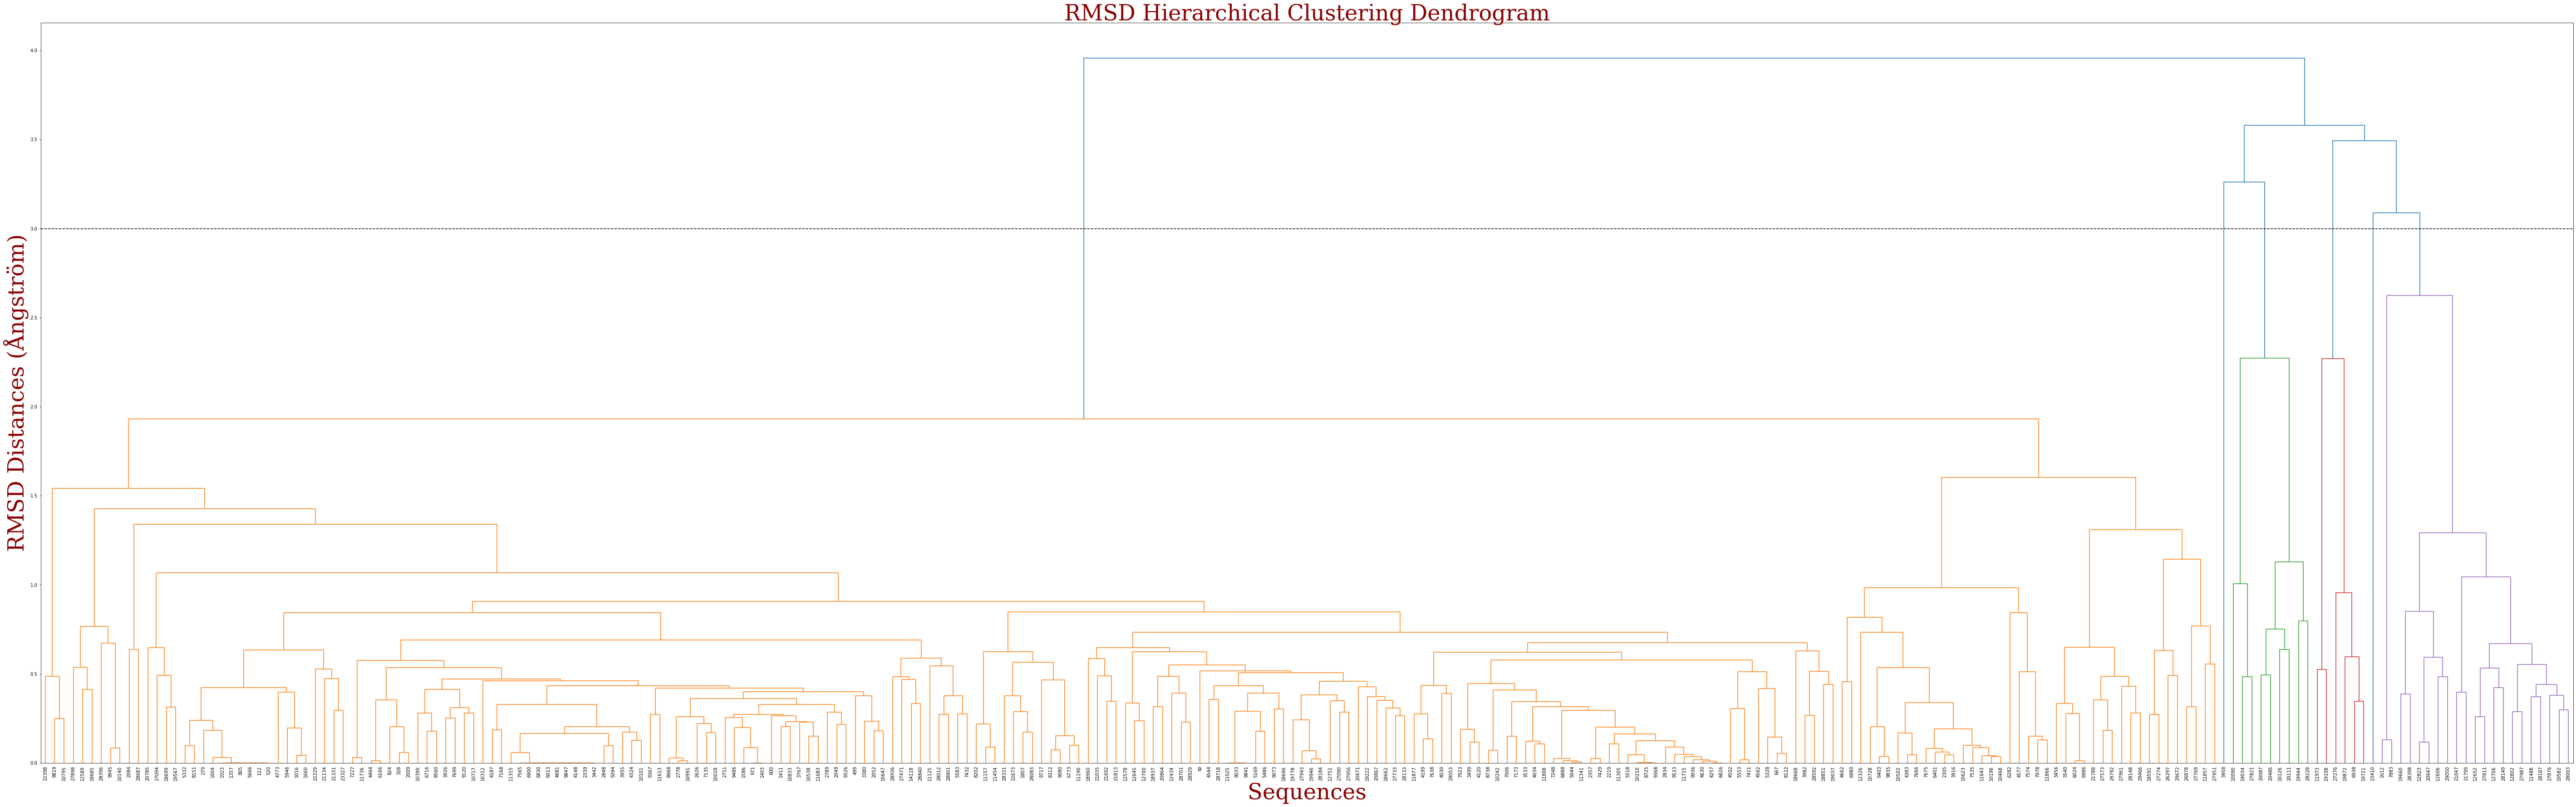

In [3]:
######################################################################
# RMSD Dendrograms
# Input: distMatrix, nameArr
# Output: dendrogram_rmsd.png
# 
# Plot RMSD Dendrograms using rmsd distance matrix and averge linkage
######################################################################


import seaborn as sns
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
import matplotlib.pyplot as plt
import pandas as pd


# Find the best hierarchical clustering method according to the cophenetic correlation
def best_cophenetic(dMatrix, methods=('single', 'complete', 'average', 'weighted', 'median', 'centroid')):
    results = {}
    for method in methods:
        Z = linkage(dMatrix, method=method)
        cophenetic_correlation, _ = cophenet(Z, dMatrix)
        results[method] = cophenetic_correlation
    results = pd.Series(results)
    return results.sort_values(ascending=False), results.idxmax()



#generate dendrogram with the seqence ID label

distMatrixC= ssd.squareform(distMatrix)

c_ranking, best_method = best_cophenetic(distMatrixC)
print('Cophenetic ranking\n%s\nbest: %s' % (c_ranking, best_method))

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 48,
        }

Z_rmsd = linkage(distMatrixC,method='average',metric='precomputed')
#cc, ccMatrix = cophenet(Z_rmsd, distMatrixC)

plt.figure(figsize=(100,30))
plt.title("RMSD Hierarchical Clustering Dendrogram", fontdict=font)
plt.ylabel ("RMSD Distances (Ångström)", fontdict=font)
plt.xlabel ("Sequences", fontdict=font)

dend_rmsd = dendrogram(
    Z_rmsd,
    labels = nameArr,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)
plt.axhline(y=3, color='black', linestyle='--')

plt.savefig('dendrogram_rmsd.png', dpi=150, facecolor = "w", edgecolor = 'b')
plt.show



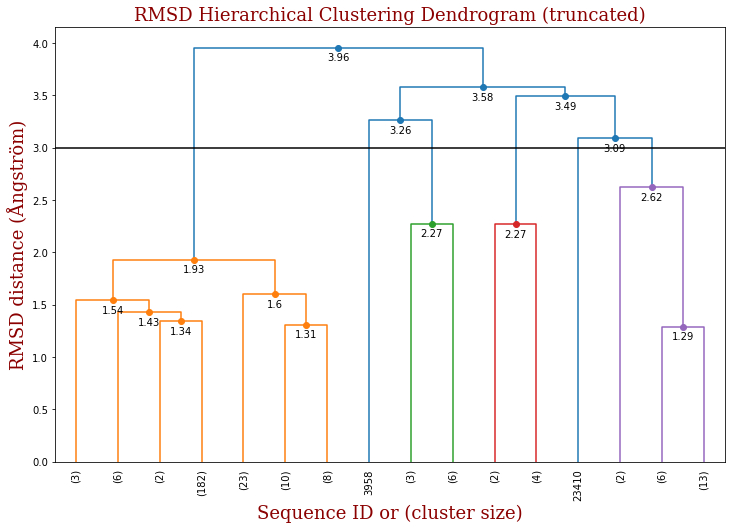

In [4]:
######################################################################
# RMSD Truncated Dendrograms
# Input: Z_rmsd, nameArr
# Output: dendrogram_rmsd_truncated.png
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# Plot RMSD truncated Dendrograms using rmsd distance matrix and averge linkage
######################################################################
#***************************************************************************************
#    Title: fancydengrogram
#    Author:  Jörn Hees
#    Date: 08/26/2015
#    Code version:
#    Availability: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#
#**************************************************************************************/


def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(12,8))
    ddata = dendrogram(*args, **kwargs)
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 18,
            }
    if not kwargs.get('no_plot', False):
        plt.title('RMSD Hierarchical Clustering Dendrogram (truncated)', fontdict=font)
        plt.xlabel('Sequence ID or (cluster size)', fontdict=font)
        plt.ylabel('RMSD distance (Ångström)', fontdict=font)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

#Z = linkage(distMatrixC,method='average',metric='precomputed')
fancy_dendrogram(
    Z_rmsd,
    truncate_mode='lastp',
    p=16,
    labels = nameArr,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,
    annotate_above=0.3,
    max_d = 3,
)
plt.savefig('dendrogram_rmsd_truncated.png')    # The saved figure does not have X label ?

In [5]:
######################################################################
# RMSD Cluster Classes
# Input: dend_rmsd
# Output: RMSD_C*.txt  (Each one of these contains the Sequence ID that belong to that cluster)
# 
# Save the sequence's ID by cluster to files for futher analysis
######################################################################
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter

cluster_idxs = defaultdict(list)
for c, pi in zip(dend_rmsd['color_list'], dend_rmsd['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html
    
#f_file = open("dend.csv",'w')
#f_file.write("Cluster,Seq,RMSD\n")

cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [dend_rmsd['ivl'][i] for i in l]
    cluster_classes[c] = i_l

    f_file= open("RMSD_%s.txt" %(c), 'w')
    f_file.write("%s\n" %(i_l))
    f_file.close()

#    print (i_l)
#f_file.close()

cluster_classes

C1,"['9819', '10795', '22398', '12589', '18685', '27898', '9945', '10140', '28396', '2084', '28687', '18699', '19567', '27094', '20785', '5332', '8151', '112', '520', '5666', '805', '1357', '1923', '1004', '279', '1016', '1660', '5946', '4773', '21331', '23327', '21134', '22229', '7227', '11736', '4464', '6166', '328', '2009', '824', '6716', '8560', '10390', '3926', '7699', '9120', '10717', '4187', '7168', '2339', '3442', '4148', '9847', '4681', '6013', '6830', '6900', '7565', '11315', '2848', '5094', '4324', '10101', '3955', '9367', '11613', '2778', '10991', '8968', '7135', '10018', '2626', '971', '1403', '1586', '9486', '2751', '1411', '10833', '10538', '11683', '3767', '600', '2049', '9326', '2789', '2052', '10647', '3380', '499', '10312', '14118', '28840', '27471', '28936', '28012', '28801', '5583', '7432', '11125', '11157', '11454', '8202', '1807', '28083', '22673', '28331', '8312', '9080', '6773', '11190', '9717', '21692', '21813', '21035', '18960', '12645', '12700', '12578', '18937', '20864', '28701', '28929', '12434', '4544', '28718', '9033', '9841', '11025', '5169', '5486', '9073', '18696', '19946', '28184', '27943', '19778', '27090', '27956', '12751', '27733', '28133', '18662', '20867', '19222', '20671', 'sp', '4199', '7638', '11877', '4030', '29053', '3499', '4120', '7923', '8738', '10242', '7006', '7173', '4034', '11808', '3533', '5044', '11341', '6888', '7248', '2357', '7429', '2219', '11305', '8725', '9368', '10210', '5518', '4257', '6826', '4630', '9936', '11715', '9533', '2834', '5553', '7411', '4502', '667', '8122', '5328', '4562', '3982', '28592', '18851', '19037', '18668', '4662', '6980', '6403', '9835', '10728', '4383', '7666', '10502', '2305', '3916', '6401', '7675', '10196', '10468', '11643', '7535', '10623', '12326', '7978', '11866', '7574', '4577', '6282', '6024', '6986', '3540', '3456', '27573', '29792', '21788', '28148', '29466', '27961', '18591', '27274', '26297', '29672', '26878', '27769', '11857', '27951']"
C2,"['19034', '27821', '10090', '20087', '20486', '10126', '20111', '19944', '28228', '20111']"
C0,"['3958', '23410']"
C3,"['11973', '19108', '6938', '19721', '19872', '27276']"
C4,"['1612', '7883', '19660', '28398', '12823', '20647', '12606', '29050', '21047', '21799', '12652', '27811', '12706', '28149', '12802', '27987', '11488', '28187', '19582', '28003', '27876', '12823']"


In [6]:
######################################################################
# RMSD Cluster Classes to fasta
# Input: df_petwRef.fasta
# Output: RMSD_Cx.fasta
# 
#Generate a fasta file for each cluster of the dendrogram, for those
# not in cluster with the reference, add reference to the end so we can 
# profrom MSA and analysis
######################################################################
for c in cluster_classes:
    f_file= open("RMSD_%s.fasta" %(c), 'w')

    #loop through each sequence ID and get it's data from df_petwRef.fasta
    for id in cluster_classes[c]:
        with open('df_petwRef.fasta','r') as file:
            for line in file:
                if id in line:
                    f_file.write(line)
                    f_file.write(next(file))
                    break
    f_file.close()
file.close()   

#read reference sequence into memory
refline = ''
with open('df_petwRef.fasta','r') as orig_file:
    for line in orig_file:
        if '>sp' in line:
                refline = line
                refline2 = next(orig_file)
                break
orig_file.close()

#add reference to all clusters if not there already
for c in cluster_classes:
    with open("RMSD_%s.fasta" %(c), 'r+') as filerw:
        found = False
        for line in filerw:
            if ">sp" in line:
                found = True
        if not found:
            filerw.write(refline)
            filerw.write(refline2)
        filerw.close()

  

Now we take load these RMSD_C*.fasta and preform MSA on each cluster.  

In [ ]:
!cat RMSD_C0.fasta | mafft --quiet - > RMSD_C0_mafft
!cat RMSD_C1.fasta | mafft --quiet - > RMSD_C1_mafft
!cat RMSD_C2.fasta | mafft --quiet - > RMSD_C2_mafft
!cat RMSD_C3.fasta | mafft --quiet - > RMSD_C3_mafft
!cat RMSD_C4.fasta | mafft --quiet - > RMSD_C4_mafft

In [7]:
######################################################################
# Convert to fasta-2line
# Input: RMSD_Cx_mafft
# Output: RMSD_Cx_mafft.fasta
# The result of mafft call above returns multiline fasta file, convert
# them back to fasta-2line format in order to do binding/active sites
# analysis
######################################################################

from Bio import SeqIO
#convert multiline sequence fasta file to single line sequence fasta file

for c in cluster_classes:
    records = SeqIO.parse("RMSD_%s_mafft" %(c), "fasta")
    count = SeqIO.write(records, "RMSD_%s_mafft.fasta" %(c), "fasta-2line")



In [10]:
######################################################################
# Analysis of Binding, Active sites and Others
# Input: RMSD_Cx_mafft.fasta
# Output: theBAOListCx.fasta, the BAListCx.fasta
#         except for Cluster C1, all other BA/BAO list with reference
#         sequence only should be ignored
# For each MSA cluster files, check if the binding sites, active sites,
# and/or other matches or conserved substituated  
######################################################################            
# from reference sequence 'sp'
# Binding Site 87, 161, 185
# Active site 160, 206, 237
# Others 159, 214

#numpy array to stored the positions (position changed after aligned) for 
#the 8 amino acids we are checking, we need to find the new index positions
pI = np.zeros(8, dtype=int)

char1 = '>'
char2 = '|'

#first find the corsponding position for these 8 amino acids in the aligned reference sequence
#loop through the fasta file until we find the reference sequence
#considering the gap generated by MSA, find the corsponding positions

for c in cluster_classes:
    print (c)
    with open("RMSD_%s_mafft.fasta" %(c), 'r') as m_file:
        for line in m_file:
            if '>' in line:
                seqID = line[line.find(char1)+1 :line.find(char2)]  
                if seqID == 'sp':
                    seqLine = next(m_file)
                    gap = '-'
                    counter = 0
                    for i,letter in enumerate(seqLine):

                        if seqLine[i] != gap:
                            counter +=1
                            if counter == 87:
                                pI[0] = i
                            elif counter == 161:
                                pI[1] = i
                            elif counter == 185:
                                pI[2] = i
                            elif counter == 160:
                                pI[3] = i
                            elif counter == 206:
                                pI[4] = i
                            elif counter == 237:
                                pI[5] = i
                            elif counter == 159:
                                pI[6] = i
                            elif counter == 214:
                                pI[7] = i

    m_file.close()
    
    print (pI)
    
    #Now we have all the index positions for the sites we are interested
    #for this cluster, find the corsponding BAO adn BA list for this cluster
    
    # matching 8 amino acids
    f_file = open("theBAOList%s.fasta" %(c), 'w')
    with open('RMSD_%s_mafft.fasta' %(c),'r') as c_file:
        for line in c_file:
            lineID = line
            lineSEQ = next(c_file)
            
            #find sequences that matches or conserved sub for all 8 amino acids
            if ((lineSEQ[pI[0]] == 'Y' or lineSEQ[pI[0]] =='F' or lineSEQ[pI[0]] =='W') and 
                (lineSEQ[pI[1]] == 'M' or lineSEQ[pI[1]] =='L' or lineSEQ[pI[1]] == 'I') and 
                (lineSEQ[pI[2]] == 'W' or lineSEQ[pI[2]] =='Y') and
                (lineSEQ[pI[3]] == 'S') and
                (lineSEQ[pI[4]] == 'D' or lineSEQ[pI[4]] =='E') and
                (lineSEQ[pI[5]] == 'H') and 
                (lineSEQ[pI[6]] =='W' or lineSEQ[pI[6]] =='H' or lineSEQ[pI[6]]=='Y' or lineSEQ[pI[6]]=='F') and 
                (lineSEQ[pI[7]] =='H' or lineSEQ[pI[7]] =='M')) :
                f_file.write(lineID)
                f_file.write(lineSEQ)
    f_file.close()
    c_file.close()
    
    # matching 6 amino acids
    f_file = open("theBAList%s.fasta" %(c),'w')
    with open('RMSD_%s_mafft.fasta' %(c),'r') as c_file:
        for line in c_file:
            lineID = line
            lineSEQ = next(c_file)

            #find sequences that matches or conserved sub for all 6 amino acids
            if ((lineSEQ[pI[0]] == 'Y' or lineSEQ[pI[0]] =='F' or lineSEQ[pI[0]] =='W') and 
                (lineSEQ[pI[1]] == 'M' or lineSEQ[pI[1]] =='L' or lineSEQ[pI[1]] == 'I') and 
                (lineSEQ[pI[2]] == 'W' or lineSEQ[pI[2]] =='Y') and
                (lineSEQ[pI[3]] == 'S') and
                (lineSEQ[pI[4]] == 'D' or lineSEQ[pI[4]] =='E') and
                (lineSEQ[pI[5]] == 'H')):
                f_file.write(lineID)
                f_file.write(lineSEQ)
    f_file.close()
    c_file.close()
    


C1
[158 236 263 235 300 335 234 308]
C2
[101 176 200 175 221 252 174 229]
C0
[ 97 171 195 170 216 247 169 224]
C3
[103 177 202 176 223 255 175 231]
C4
[123 198 223 197 250 282 196 258]


# Dissimiliarity Matrix

Cophenetic ranking
average     0.911011
weighted    0.881525
centroid    0.870415
median      0.864454
complete    0.852175
single      0.830703
dtype: float64
best: average


<function matplotlib.pyplot.show(close=None, block=None)>

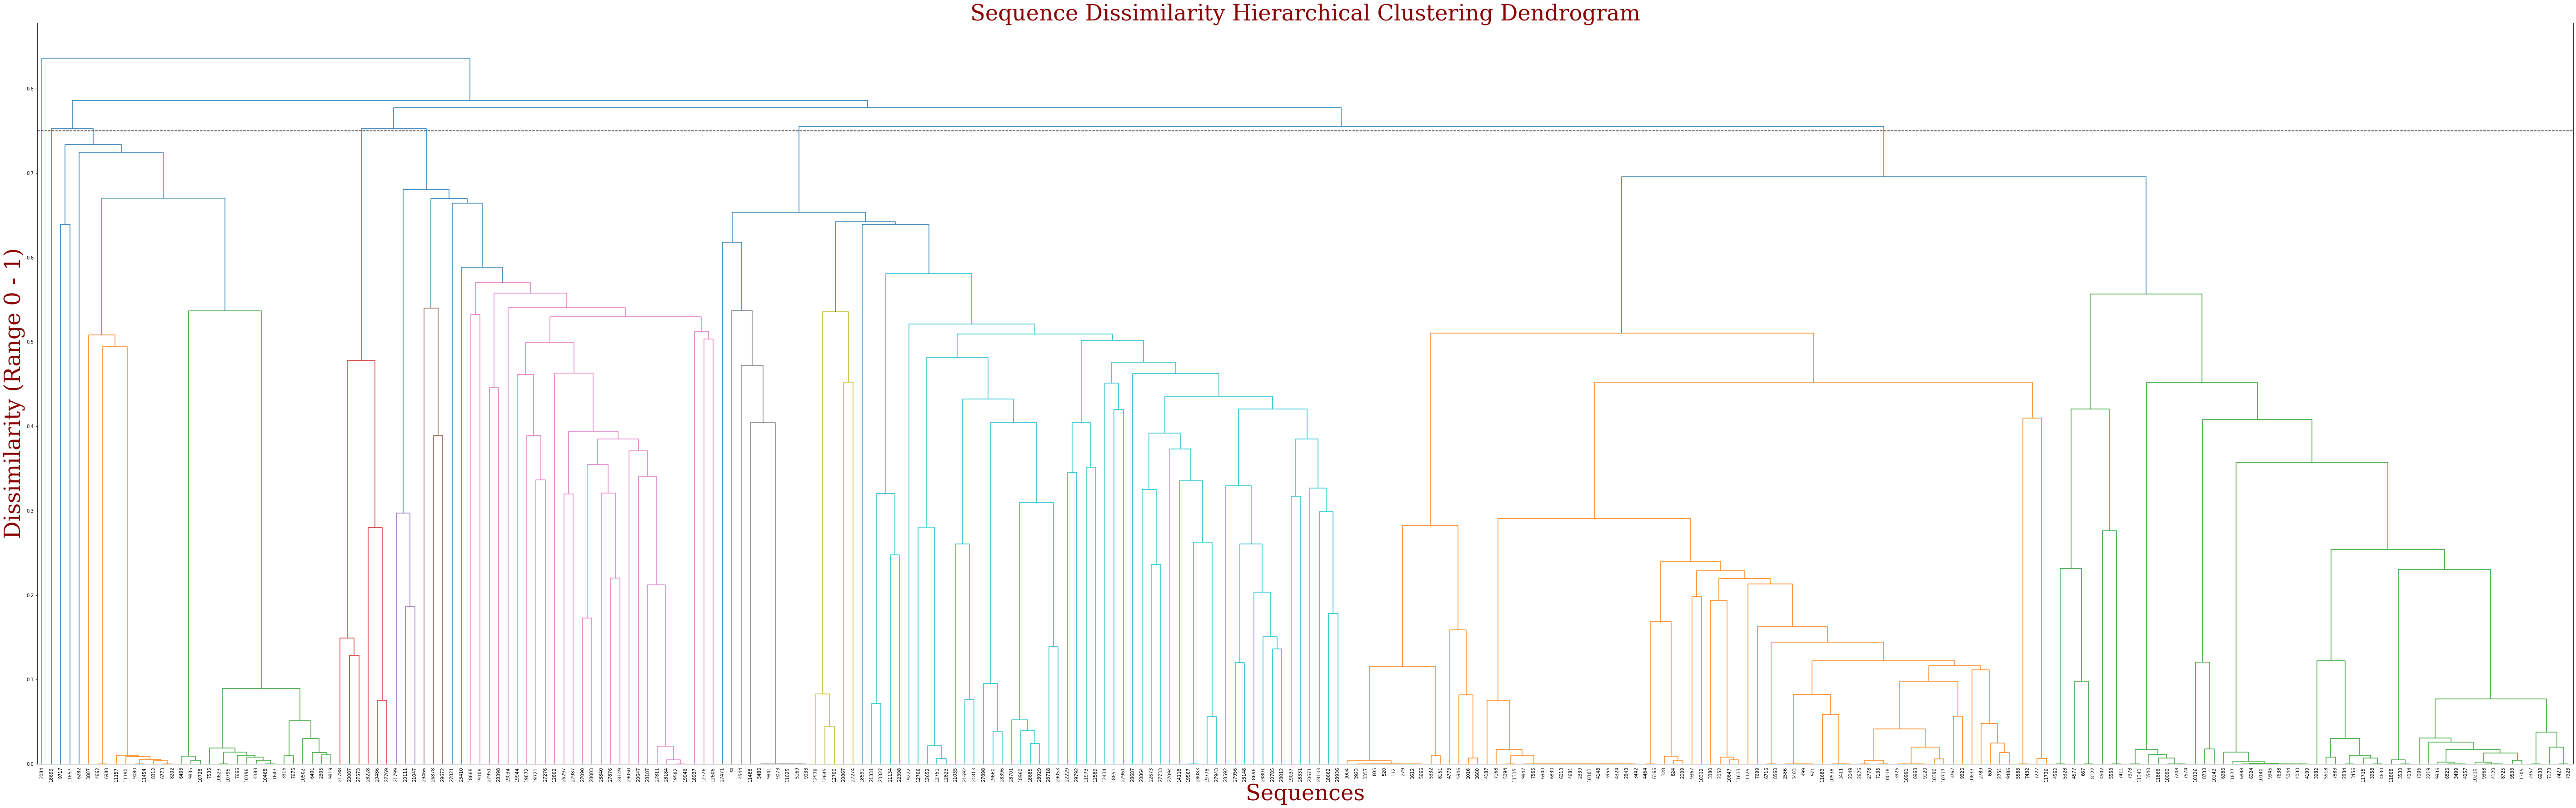

In [4]:
######################################################################
# Indentity Dendrograms using Dissimiliaity Matrix (generated by Clustal Omega)
# Input: dissimMatrix, nameArr
# Output: dendrogram_dis.png
# Clustering Cutoff line = 0.75
# Plot Indentity Dendrograms using using dissimiliaity matrix and averge linkage
######################################################################
#import seaborn as sns
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

#sns.set_style("darkgrid")

dissimMatrixC= ssd.squareform(dissimMatrix)

c_ranking, best_method = best_cophenetic(dissimMatrixC)
print('Cophenetic ranking\n%s\nbest: %s' % (c_ranking, best_method))



Z_diss = linkage(dissimMatrixC,method=best_method,metric='precomputed')     #ward, average, weighted, centroid, medium, single, complete
#ccs, ccsMatrix = cophenet(Z_diss, dissimMatrixC)

plt.figure(figsize=(100,30))
dend_diss = dendrogram(
    Z_diss,
#    truncate_mode='lastp',
    labels = nameArr,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)
plt.axhline(y=0.75, color='black', linestyle='--')
plt.title("Sequence Dissimilarity Hierarchical Clustering Dendrogram", fontdict=font)
plt.ylabel ("Dissimilarity (Range 0 - 1)", fontdict=font)
plt.xlabel ("Sequences", fontdict=font)
plt.savefig('dendrogram_dis.png', dpi=150, facecolor = "w", edgecolor = 'b')
plt.show

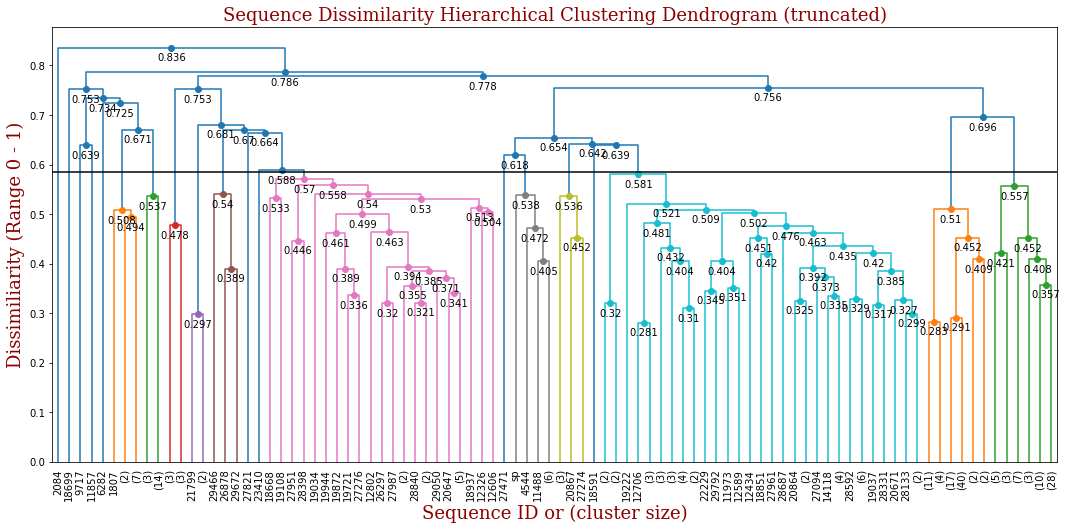

In [6]:
######################################################################
# Identity Truncated Dendrograms
# Input: Z_diss, nameArr
# Output: dendrogram_diss_truncated.png
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# Plot Identity truncated Dendrograms using dissimilarity matrix and averge linkage
######################################################################

def fancy_dendrogram1(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(18,8))
    ddata = dendrogram(*args, **kwargs)
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 18,
            }
    if not kwargs.get('no_plot', False):
        plt.title('Sequence Dissimilarity Hierarchical Clustering Dendrogram (truncated)', fontdict=font)
        plt.xlabel('Sequence ID or (cluster size)', fontdict=font)
        plt.ylabel('Dissimiliarity (Range 0 - 1)', fontdict=font)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

dendsf = fancy_dendrogram1(
    Z_diss,
    truncate_mode='lastp',
    p=90,
    labels = nameArr,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,
    annotate_above=0.2,
    max_d = 0.585
)
plt.savefig('dendrogram_diss_truncated.png')    # The saved figure does not have X label ?

In [10]:
######################################################################
# Identity Cluster Classes (for the truncated dendrogram)
# Input: dendsf
# Output: 
# 
# Save the sequence's ID by cluster to files for futher analysis
######################################################################
import matplotlib
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter

cluster_idxs = defaultdict(list)
for c, pi in zip(dendsf['color_list'], dendsf['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html
    

cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [dendsf['ivl'][i] for i in l]
    cluster_classes[c] = i_l
#    print (c)
#    f_file= open("IDENTr_%s.txt" %(c), 'w')
#    f_file.write("%s\n" %(i_l))
#    f_file.close()

#    print (i_l)
#f_file.close()

cluster_classes

C0,"['9717', '11857', '6282', '18699', '23410', '27821', '27471', '18591', '(17)', '2084']"
C1,"['(2)', '(7)', '1807', '(11)', '(4)', '(17)', '(40)', '(2)', '(2)']"
C2,"['(3)', '(14)', '(5)', '(3)', '(10)', '(28)', '(3)', '(7)']"
C3,"['(3)', '(3)']"
C4,"['21799', '(2)']"
C5,"['26878', '29672', '29466']"
C6,"['18668', '19108', '27951', '28398', '19721', '27276', '19872', '19944', '26297', '27987', '28840', '(2)', '(2)', '20647', '(5)', '29050', '12802', '12326', '12606', '18937', '19034']"
C7,"['11488', '(6)', '4544', 'sp']"
C8,"['20867', '27274', '(3)']"
C9,"['(2)', '(2)', '12706', '(3)', '(4)', '(2)', '(3)', '(3)', '22229', '29792', '11973', '12589', '18851', '27961', '12434', '20864', '(2)', '14118', '(4)', '27094', '28592', '(6)', '19037', '28331', '28133', '(2)', '20671', '28687', '19222']"


In [11]:
######################################################################
# Identity Cluster Classes
# Input: dend_diss
# Output: IDEN_C*.txt  (Each one of these contains the Sequence ID that belong to that cluster)
# 
# Save the sequence's ID by cluster to files for futher analysis
######################################################################
import matplotlib
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter

cluster_idxs = defaultdict(list)
for c, pi in zip(dend_diss['color_list'], dend_diss['icoord']):
    for leg in pi[1:3]:
        i = (leg - 5.0) / 10.0
        if abs(i - int(i)) < 1e-5:
            cluster_idxs[c].append(int(i))

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        
        return html
    

cluster_classes = Clusters()
for c, l in cluster_idxs.items():
    i_l = [dend_diss['ivl'][i] for i in l]
    cluster_classes[c] = i_l
#    print (c)
    f_file= open("IDEN_%s.txt" %(c), 'w')
    f_file.write("%s\n" %(i_l))
    f_file.close()

#    print (i_l)

cluster_classes

C0,"['9717', '11857', '6282', '18699', '23410', '27821', '27471', '18591', '2084']"
C1,"['4662', '6980', '9080', '11454', '6773', '8202', '8312', '11190', '11157', '1807', '112', '279', '520', '805', '1357', '1923', '1612', '5666', '1004', '5332', '8151', '1016', '1660', '5946', '4773', '5094', '11315', '2339', '10101', '2848', '3442', '4324', '3955', '4148', '4681', '6013', '6830', '6900', '7565', '9847', '7168', '4187', '4464', '6166', '824', '2009', '328', '9367', '10312', '10647', '11613', '2052', '3380', '6716', '8560', '499', '971', '1403', '1586', '1411', '2049', '10538', '11683', '2626', '2778', '7135', '10018', '3926', '10991', '8968', '9120', '10390', '10717', '9120', '3767', '9326', '2751', '9486', '600', '2789', '10833', '7699', '11125', '5583', '7432', '7227', '11736']"
C2,"['9835', '10728', '6403', '10623', '10795', '10468', '11643', '4383', '10196', '7666', '7535', '3916', '7675', '2305', '9819', '6401', '10502', '4562', '5328', '667', '8122', '4577', '5553', '7411', '4502', '7978', '11341', '7248', '7574', '10090', '11866', '3540', '8738', '10242', '10126', '6024', '10140', '6888', '4030', '4199', '5044', '7638', '9945', '11877', '6986', '5518', '7883', '2834', '3456', '3958', '4630', '11715', '3982', '3533', '4034', '11808', '3499', '4257', '6826', '9936', '4120', '8725', '9368', '10210', '9533', '11305', '2219', '7006', '2357', '6938', '7429', '7923', '7173']"
C3,"['20087', '27573', '21788', '20486', '27769', '28228']"
C4,"['20111', '21047', '21799']"
C5,"['26878', '29672', '29466']"
C6,"['18668', '19108', '27951', '28398', '19721', '27276', '19872', '19944', '26297', '27987', '27090', '28003', '27876', '28149', '28840', '19582', '19946', '28184', '27811', '28187', '20647', '29050', '12802', '12326', '12606', '18937', '19034']"
C7,"['5486', '9841', '5169', '9033', '11025', '9073', '11488', '4544', 'sp']"
C8,"['12645', '12700', '12578', '20867', '27274']"
C9,"['21331', '23327', '21134', '22398', '12751', '12823', '12652', '12706', '21692', '21813', '21035', '19660', '28396', '27898', '18685', '28929', '18960', '28701', '28718', '29053', '22229', '29792', '11973', '12589', '18851', '27961', '12434', '22673', '27733', '20864', '19567', '28083', '19778', '27943', '14118', '27094', '27956', '28148', '20785', '28012', '28801', '18696', '28592', '19037', '28331', '18662', '28936', '28133', '20671', '28687', '19222']"


In [13]:
######################################################################
# PearsonCorr
# Input: Z_rmsd, distMatrixC, Z_diss, disssimMatrixC
# Output: Pearson correlation coefficient
# 
# Calculated the correlation coefficient between RMSD and Identity
######################################################################
from scipy.stats import pearsonr

cc, ccMatrix = cophenet(Z_rmsd, distMatrixC)
ccs, ccsMatrix = cophenet(Z_diss, dissimMatrixC)

cophenetic_pearson, p_value_cophenetic = pearsonr(ccMatrix, ccsMatrix)

print (cophenetic_pearson)
#verifing we can the same correlation coefficient with numpy's corrcoef 
c = np.corrcoef(ccMatrix,ccsMatrix)
print (c)

0.31375614080299796
[[1.         0.31375614]
 [0.31375614 1.        ]]


INFO  : Generating linkage from distances (tangle)
INFO  : Generating linkage from distances (tangle)
INFO  : Finished optimising at entanglement 0.12 (tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tangle)


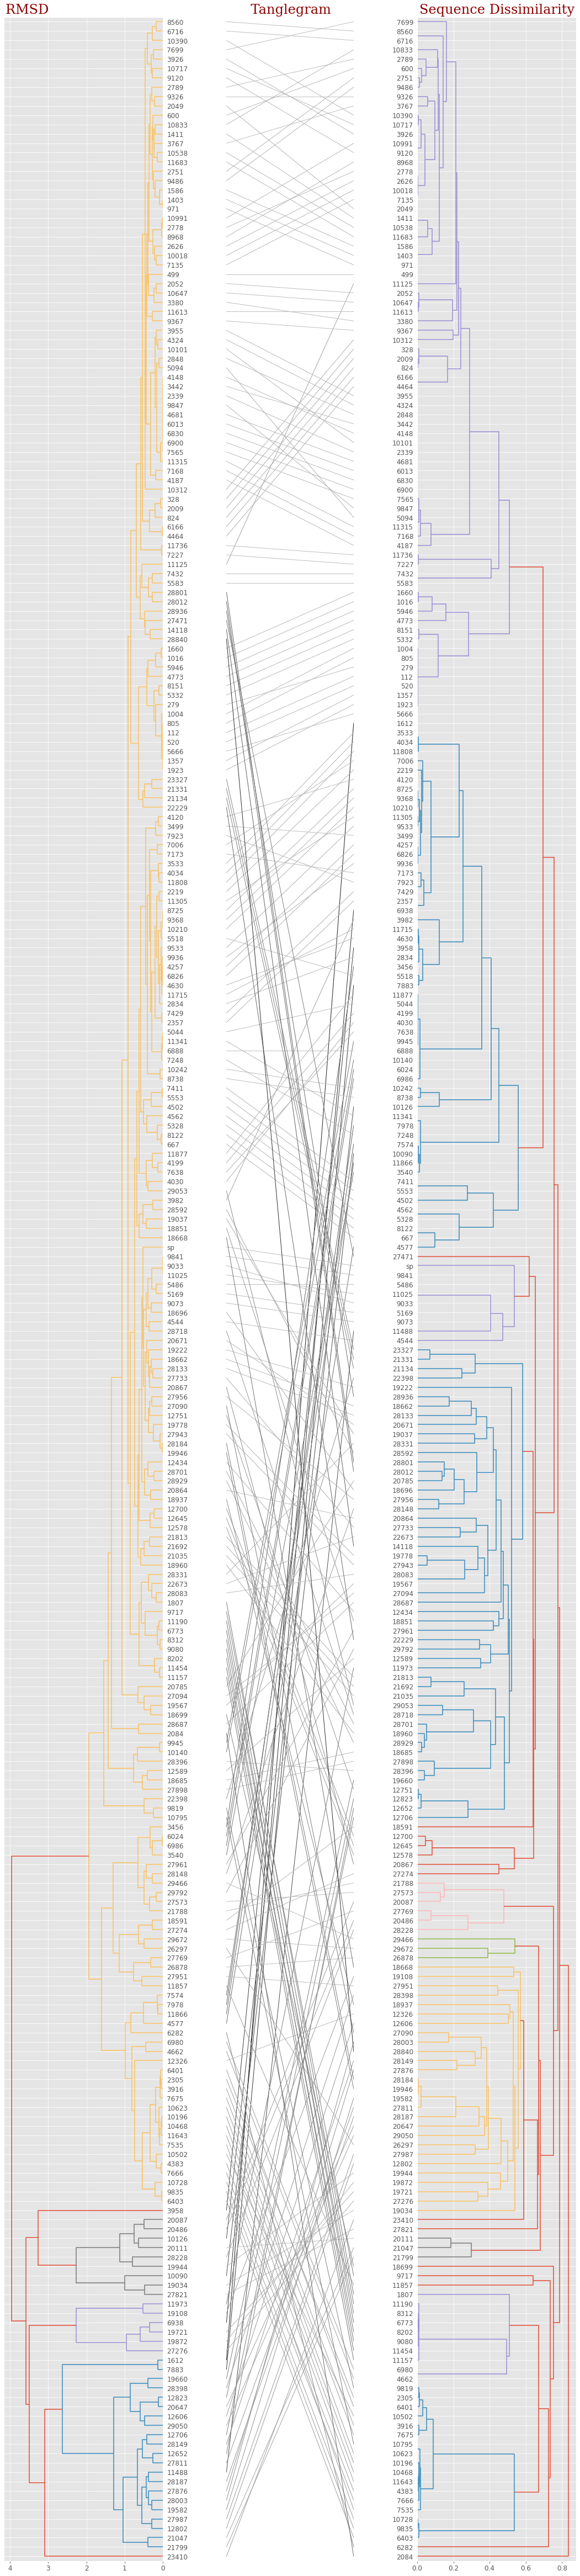

In [7]:
######################################################################
# Tanglegram
# Input: nameArr, distMatrix, dissimMatrix
# Output: tanglegram.png
# 
# Utilize tanglegram package to plot the RMSD vs. Identity dengrogram
######################################################################
#import tanglegram as tg
from tangle import plot as tangleplot  #tangle.py in the local directory
import matplotlib.pyplot as plt
import pandas as pd

# Generate two distance matrices and just switch labels in one
labelsA= nameArr
labelsB= nameArr
dataA = distMatrix
dataB = dissimMatrix

mat1 = pd.DataFrame(dataA,
                    columns=labelsA,
                    index=labelsA)

mat2 = pd.DataFrame(dataB,
                    columns=labelsB,
                    index=labelsB)

# Plot tanglegram
#link = {"method='average'"}
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 24,
        }       

fig = tangleplot(mat1, mat2, sort= 'step2side')
plt.title('RMSD                                                Tanglegram                     Sequence Dissimilarity', fontdict=font)
plt.savefig('tanglegram.png', dpi=150, facecolor = "w", edgecolor = 'b')
plt.show()

In [11]:
######################################################################
# locationInfo for BAList for Cluster C1
# Input: df_pet.tsv
# Output: df_pet_theBAListC1_origin.csv
# 
# Get Country and Dataset info (into a csv file) for the sequences in 
# the BA List of RMSD cluster C1
######################################################################
lines = open("df_pet.tsv").readlines()
f_file = open("df_pet_theBAListC1_origin.csv",'w')
#l_file = open("theBAListC1.fasta", 'r')

char1 = '>'
char2 = '|'

f_file.write("SeqID"+", "+"Country"+", "+"Dataset"+"\n")

with open('theBAListC1.fasta','r') as l_file:
    for l_line in l_file:
        if '>' in l_line:
            seqID = l_line[l_line.find(char1)+1 :l_line.find(char2)]
            for line in lines[1:]:
                cols = line.split("\t")
                if cols[0] == seqID:
                    f_file.write(cols[0]+", "+cols[7]+", "+cols[9]+"\n")
                
    

f_file.close()
l_file.close()